<a href="https://colab.research.google.com/github/ptl-harsh/QLab_Task/blob/main/P2T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Denoising using Unet architecture

In [1]:
#@title Step 1: Mount Google Drive and Install Required Libraries
from google.colab import drive
drive.mount('/content/drive')

!pip install torch torchvision torchaudio scikit-image


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully u

In [2]:
#@title Step 2: Import Libraries and Set Up Environment
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
from PIL import Image

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


In [3]:
#@title Step 3: Define the Dataset for CBSD68 (Using "original_png" for clean images)
base_dir = "/content/drive/MyDrive/IISC_intern_task/CBSD68"  # Update if needed

noisy_dir = os.path.join(base_dir, "noisy35")
clean_dir = os.path.join(base_dir, "original_png")

class CBSD68Dataset(Dataset):
    def __init__(self, noisy_dir, clean_dir, transform=None):
        self.noisy_paths = sorted(glob.glob(os.path.join(noisy_dir, "*.png")))
        self.clean_paths = sorted(glob.glob(os.path.join(clean_dir, "*.png")))
        self.transform = transform

        if len(self.noisy_paths) == 0 or len(self.clean_paths) == 0:
            raise ValueError("No images found. Check your directory paths and file extensions.")
        if len(self.noisy_paths) != len(self.clean_paths):
            raise ValueError("Mismatch in number of noisy and clean images.")

    def __len__(self):
        return len(self.noisy_paths)

    def __getitem__(self, idx):
        noisy_img = Image.open(self.noisy_paths[idx]).convert("RGB")
        clean_img = Image.open(self.clean_paths[idx]).convert("RGB")

        if self.transform:
            noisy = self.transform(noisy_img)
            clean = self.transform(clean_img)
        else:
            to_tensor = transforms.ToTensor()
            noisy = to_tensor(noisy_img)
            clean = to_tensor(clean_img)

        return noisy, clean

# Define a transform: Resize images to 256x256 and convert to tensor.
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # Converts image to tensor with values in [0,1]
])

dataset = CBSD68Dataset(noisy_dir, clean_dir, transform=transform)
print("Number of image pairs:", len(dataset))


Number of image pairs: 68


In [4]:
#@title Step 4: Define the U-Net Model for Image Denoising
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Downward part
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Upward part
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)  # upsample
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = torch.nn.functional.interpolate(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# Initialize the U-Net model
model = UNet(in_channels=3, out_channels=3)
print(model)


UNet(
  (downs): ModuleList(
    (0): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): Double

In [5]:
#@title Step 5: Set Up Training Parameters and DataLoader
num_epochs = 50
batch_size = 32
learning_rate = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


Epoch [1/50], Loss: 0.517286
Epoch [2/50], Loss: 0.207290
Epoch [3/50], Loss: 0.097350
Epoch [4/50], Loss: 0.041978
Epoch [5/50], Loss: 0.022168
Epoch [6/50], Loss: 0.011731
Epoch [7/50], Loss: 0.012031
Epoch [8/50], Loss: 0.008330
Epoch [9/50], Loss: 0.006985
Epoch [10/50], Loss: 0.006413
Epoch [11/50], Loss: 0.005839
Epoch [12/50], Loss: 0.005878
Epoch [13/50], Loss: 0.006293
Epoch [14/50], Loss: 0.004843
Epoch [15/50], Loss: 0.006446
Epoch [16/50], Loss: 0.007269
Epoch [17/50], Loss: 0.004393
Epoch [18/50], Loss: 0.005398
Epoch [19/50], Loss: 0.004124
Epoch [20/50], Loss: 0.004883
Epoch [21/50], Loss: 0.006780
Epoch [22/50], Loss: 0.005886
Epoch [23/50], Loss: 0.004663
Epoch [24/50], Loss: 0.004060
Epoch [25/50], Loss: 0.004753
Epoch [26/50], Loss: 0.003490
Epoch [27/50], Loss: 0.005132
Epoch [28/50], Loss: 0.005780
Epoch [29/50], Loss: 0.003527
Epoch [30/50], Loss: 0.004840
Epoch [31/50], Loss: 0.006686
Epoch [32/50], Loss: 0.004196
Epoch [33/50], Loss: 0.005032
Epoch [34/50], Loss

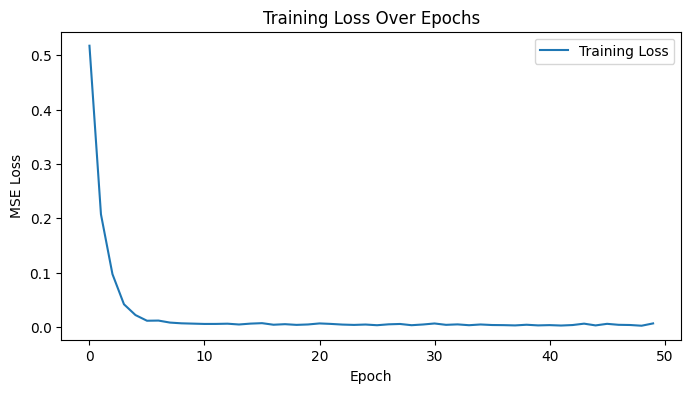

In [6]:
#@title Step 6: Train the U-Net Model
model.train()
train_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for noisy_imgs, clean_imgs in dataloader:
        noisy_imgs = noisy_imgs.to(device)
        clean_imgs = clean_imgs.to(device)

        optimizer.zero_grad()
        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()


In [9]:
#@title Step 7: Evaluate the Model and Compute PSNR & SSIM

# Denoising function
def denoise_image(model, noisy_img):
    model.eval()
    with torch.no_grad():
        noisy_img = noisy_img.unsqueeze(0).to(device)
        denoised = model(noisy_img)
    return denoised.squeeze(0).cpu()

# Convert tensor image to NumPy format (0-255 range)
def tensor_to_img(tensor_img):
    np_img = tensor_img.clamp(0, 1).permute(1, 2, 0).numpy()
    np_img = (np_img * 255).astype(np.uint8)
    return np_img

num_eval = 5
psnr_list = []
ssim_list = []

for idx in range(num_eval):
    noisy, clean = dataset[idx]  # Load noisy & clean images
    denoised = denoise_image(model, noisy)

    noisy_np = tensor_to_img(noisy)
    clean_np = tensor_to_img(clean)
    denoised_np = tensor_to_img(denoised)

    # Print image sizes for debugging
    print(f"Image {idx+1} shape: {clean_np.shape}")

    # Ensure images are at least 7x7, otherwise, use win_size=3
    win_size = 7 if min(clean_np.shape[:2]) >= 7 else 3

    # Compute PSNR and SSIM
    psnr = compare_psnr(clean_np, denoised_np, data_range=255)
    ssim = compare_ssim(clean_np, denoised_np, win_size=win_size, channel_axis=-1, data_range=255)

    psnr_list.append(psnr)
    ssim_list.append(ssim)

    print(f"Image {idx+1} - PSNR: {psnr:.2f}, SSIM: {ssim:.4f}")

# Print average scores
print(f"\nAverage PSNR: {np.mean(psnr_list):.2f}")
print(f"Average SSIM: {np.mean(ssim_list):.4f}")


Image 1 shape: (256, 256, 3)
Image 1 - PSNR: 30.40, SSIM: 0.7094
Image 2 shape: (256, 256, 3)
Image 2 - PSNR: 22.88, SSIM: 0.6913
Image 3 shape: (256, 256, 3)
Image 3 - PSNR: 28.35, SSIM: 0.7586
Image 4 shape: (256, 256, 3)
Image 4 - PSNR: 28.00, SSIM: 0.8417
Image 5 shape: (256, 256, 3)
Image 5 - PSNR: 27.61, SSIM: 0.8201

Average PSNR: 27.44
Average SSIM: 0.7642


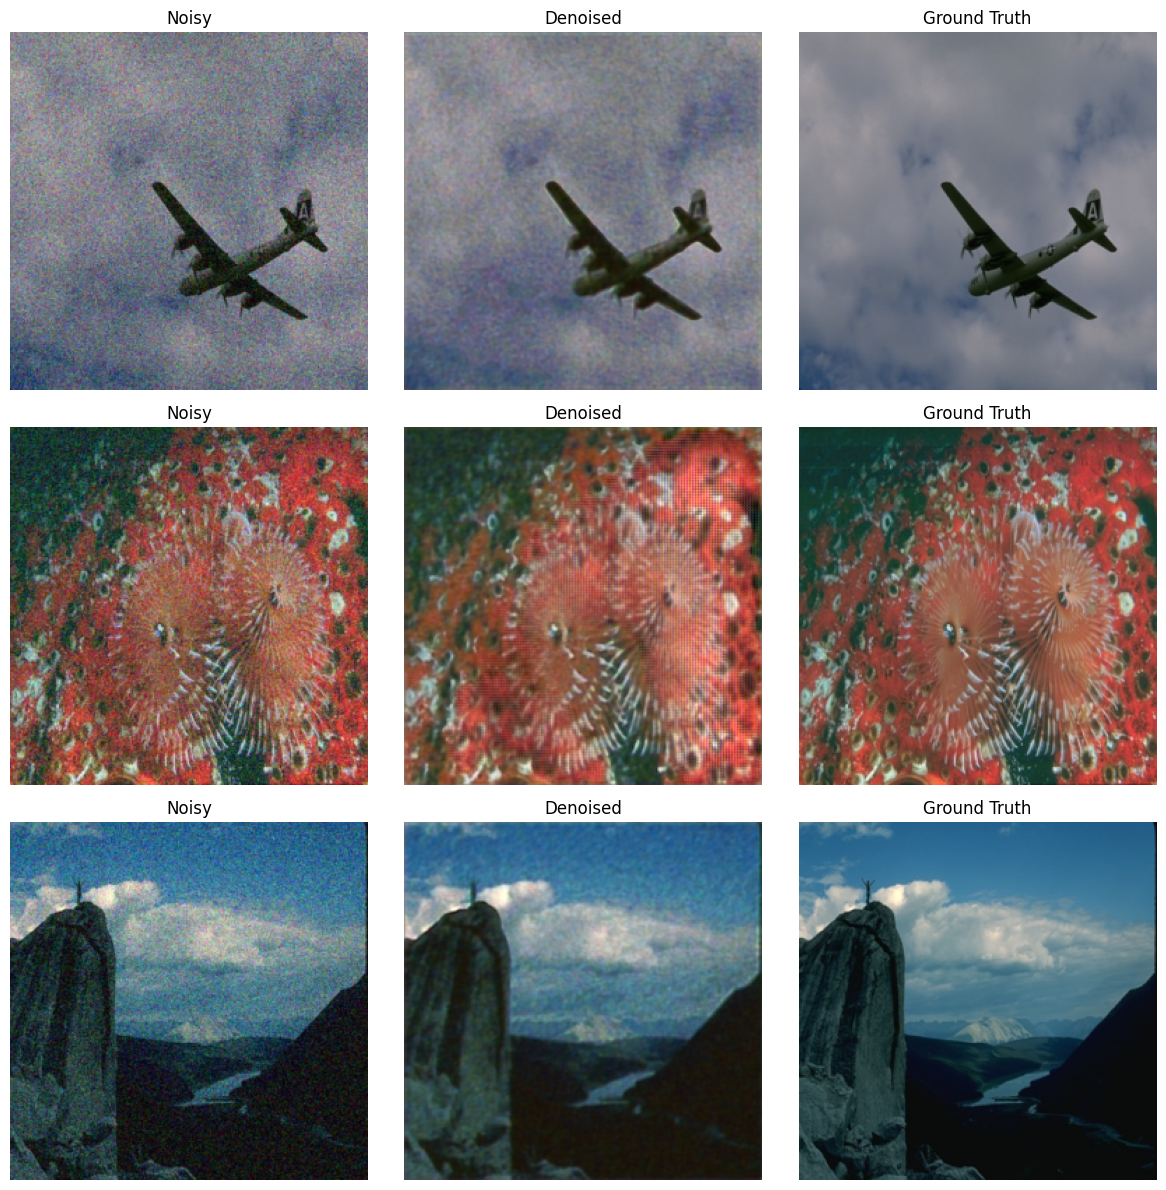

In [10]:
#@title Step 8: Visualize Denoising Results
num_display = 3
plt.figure(figsize=(12, num_display * 4))

for i in range(num_display):
    noisy, clean = dataset[i]
    denoised = denoise_image(model, noisy)

    noisy_np = tensor_to_img(noisy)
    clean_np = tensor_to_img(clean)
    denoised_np = tensor_to_img(denoised)

    # Display images: Noisy, Denoised, Ground Truth
    plt.subplot(num_display, 3, i * 3 + 1)
    plt.imshow(noisy_np)
    plt.title("Noisy")
    plt.axis("off")

    plt.subplot(num_display, 3, i * 3 + 2)
    plt.imshow(denoised_np)
    plt.title("Denoised")
    plt.axis("off")

    plt.subplot(num_display, 3, i * 3 + 3)
    plt.imshow(clean_np)
    plt.title("Ground Truth")
    plt.axis("off")

plt.tight_layout()
plt.show()
